# Test MLP width, height and regularisation

## Main Questions

* Is a narrow architecture smoother
* Is regularisation helping to make it smoother
* Are the different y encoding different in smoothness.

In [20]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'n_wdr'

folder = f'../../runs/{run}/train'
merged_folder = f'../../runs/{run}/merged'
plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']

def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

In [3]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

to_string = ['layers', 'hidden_size']
metrics_df[to_string] = metrics_df[to_string].astype(str)
synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['layers', 'y_encoding', 'hidden_size', 'regularisation', 'lr']


## Overview

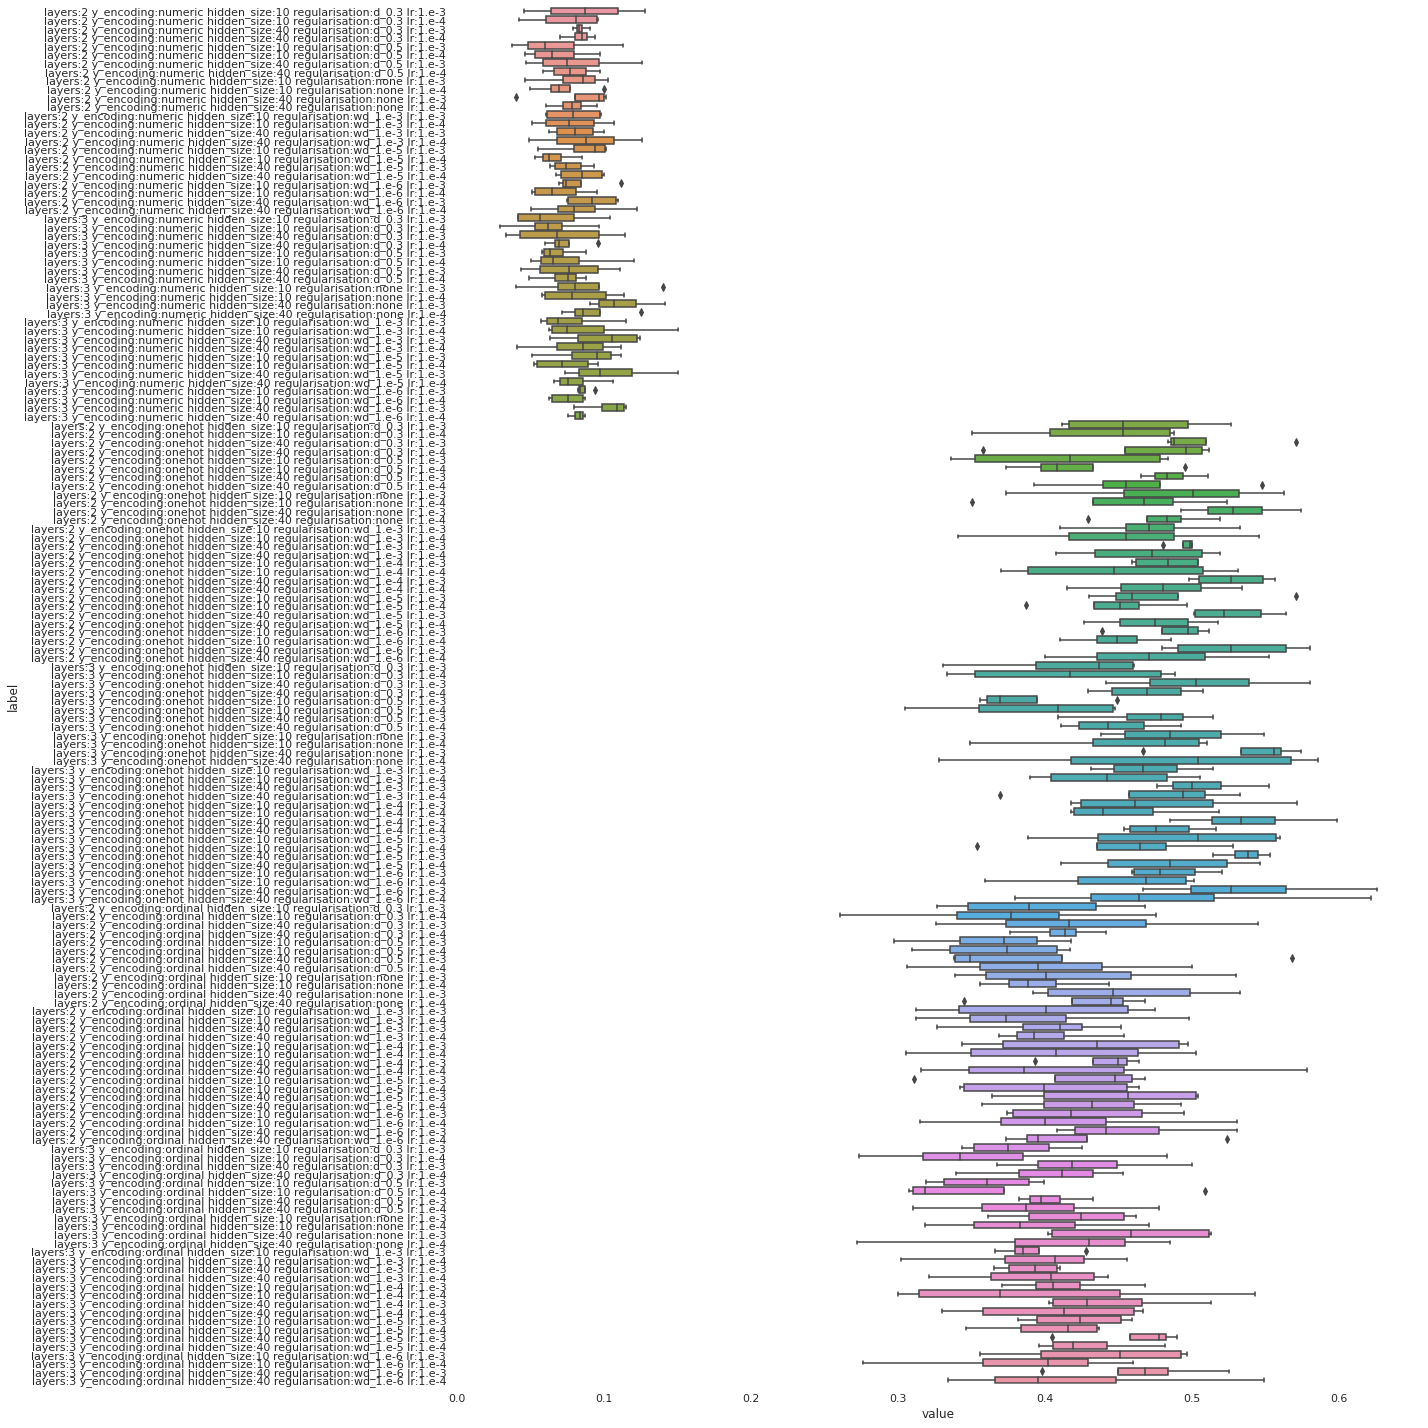

In [4]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') & 
    # (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
# df['y_ordinal'] = df['y_ordinal'].astype(str)
df = df.sort_values(['y_encoding', 'layers', 'regularisation', 'hidden_size',  'lr'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=20)

### First conclusion

* Numeric encoding did not work (investigate scaling)

## Statistical analysis of grid

In [22]:
label_ref = {
    'regularisation': 'none',
    'layers': 2,
    'hidden_size': 10,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [46]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')
results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')


metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.446654,0.022058,20.248802,3.639821e-91,0.403421,0.489888
y_encoding[T.ordinal],-0.047830,0.023771,-2.012148,4.420432e-02,-0.094420,-0.001240
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.038337,0.023771,1.612767,1.067952e-01,-0.008253,0.084926
"C(hidden_size, Treatment(reference='10'))[T.40]",0.036742,0.023771,1.545679,1.221822e-01,-0.009848,0.083332
"y_encoding[T.ordinal]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.018513,0.015847,-1.168251,2.427055e-01,-0.049573,0.012546


### Accuracy

#### Strong evidence
* onehot > ordinal

#### Some indication
* hidden_size: 10 > 40
* learning rate: '1.e-4' > '1.e-3' (not for ordinal encoding)

In [42]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.10].sort_values('P>|z|')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,3.210928,0.125305,25.624887,8.057007e-145,2.965335,3.456521
"C(regularisation, Treatment(reference='none'))[T.d_0.5]",0.554344,0.168415,3.291527,9.964507e-04,0.224256,0.884432
"y_encoding[T.ordinal]:C(regularisation, Treatment(reference='none'))[T.d_0.5]",-0.362177,0.168415,-2.150499,3.151574e-02,-0.692265,-0.032089
y_encoding[T.ordinal],-0.265425,0.135033,-1.965636,4.934064e-02,-0.530084,-0.000766
"y_encoding[T.ordinal]:C(hidden_size, Treatment(reference='10'))[T.40]",0.170570,0.090022,1.894766,5.812336e-02,-0.005869,0.347010
"C(hidden_size, Treatment(reference='10'))[T.40]:C(regularisation, Treatment(reference='none'))[T.d_0.5]",-0.316972,0.168415,-1.882086,5.982440e-02,-0.647060,0.013116


### mean absolute error

#### Strong evidence
* ordinal > onehot
* regularisation: dropout 0.5 is bad, not so much with ordinal encoding

#### Some indication
* for ordinal encoding: hiddensize 10 > 40 (dropout 0.5 helps)

## Best parameters

In [48]:
best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    metrics_df = metrics_df.reset_index(drop=True)
    gb_col = list(set(metrics_df.columns) - set(['cv_split', 'value']))
    df_g = metrics_df.groupby(gb_col)['value'].median().reset_index()
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is layers:3 y_encoding:ordinal hidden_size:40 regularisation:wd_1.e-6 lr:1.e-3.
                      name    set     value
63596             accuracy   test  0.468497
63597             accuracy  train  0.462778
63598  mean_absolute_error   test  2.563471
63599  mean_absolute_error  train  2.609259
Best performance for metric accuracy is layers:3 y_encoding:onehot hidden_size:40 regularisation:none lr:1.e-3.
                      name    set     value
49196             accuracy   test  0.556305
49197             accuracy  train  0.537037
49198  mean_absolute_error   test  2.747656
49199  mean_absolute_error  train  2.746111


### Summary

* We have the highest accuracy and mae for
    * 3 layer
    * low regularisation 
    * hidden_size of 40
    * learning rate of 1.e-3
* Ordinal y is leading to a better mae, onehot y to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

y_encoding=ordinal|regularisation=wd_1.e-6|lr=1.e-3|epoch=990


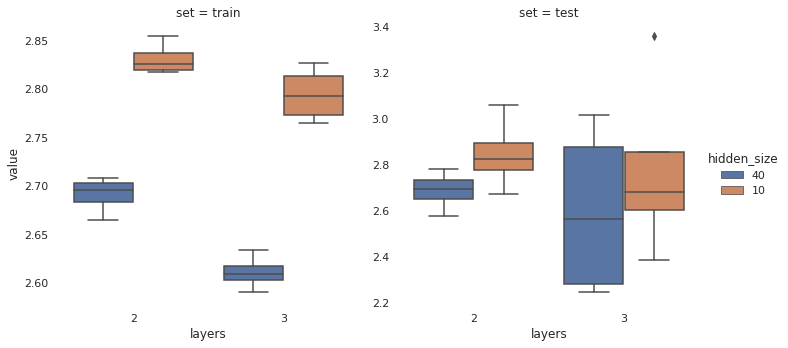

In [9]:
selection = best_labels['mean_absolute_error'].copy()

focus = ['layers', 'hidden_size']
metric_name = 'mean_absolute_error'

for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=False)
print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* Number of layers has a relative small effect on mae
* Number of hidden units has a large effect on the training set and a small effect on the test set (overfitting!)

### Hidden Size and regularisation

layers=3|y_encoding=ordinal|lr=1.e-3|epoch=990


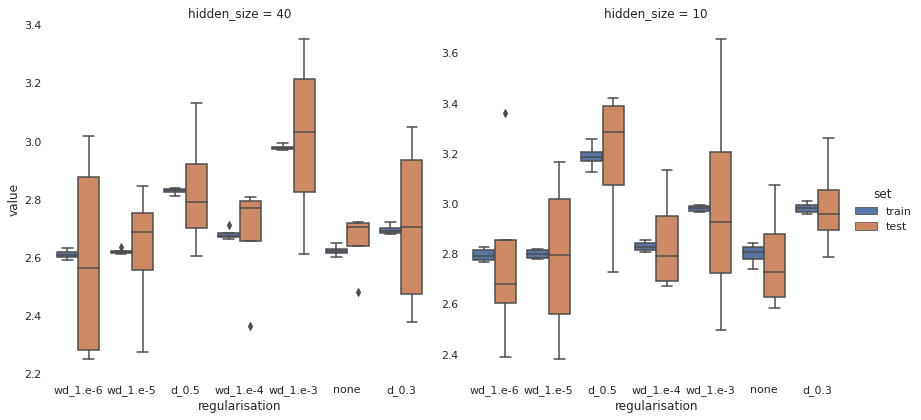

In [10]:
selection = best_labels['mean_absolute_error'].copy()

focus = ['hidden_size', 'regularisation']
metric_name = 'mean_absolute_error'

selection = {k: v for k, v in selection.items() if k not in focus}
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)
sns.catplot(data=metrics_df[w1 & w2], col=focus[0], x=focus[1], y='value', hue='set', kind='box', sharey=False, height=6)
print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* The non regularised model has the lowest cv variance in test performance
* No clear benefit in regularisation
* Mild weight decay decreases test error, but at the expense of high variance.

## Confusion Matrix

<AxesSubplot:xlabel='y_pred', ylabel='y_true'>

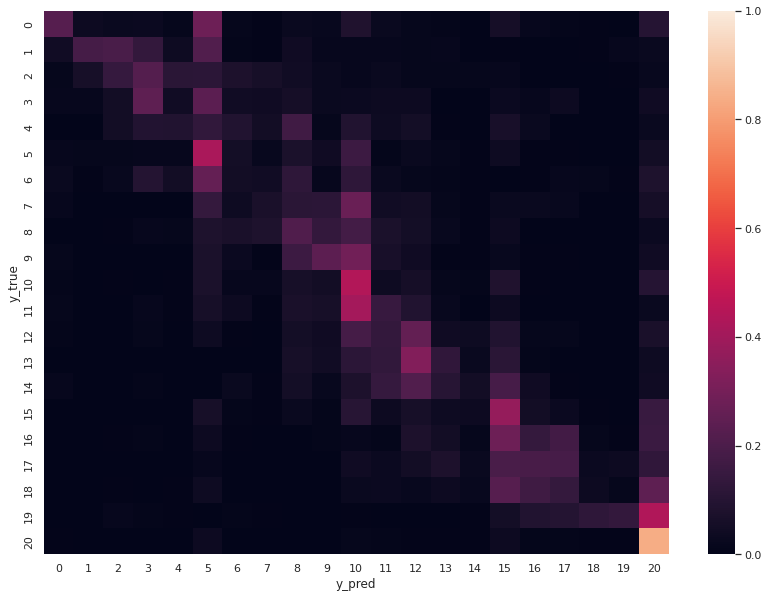

In [11]:
# Todo: double check the normalisation
w = pd.concat(
    (confusion_matrix_df[k] == v
    for k,v in best_labels['mean_absolute_error'].items()), axis=1
).all(1)

cm_g_df = confusion_matrix_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)

## 

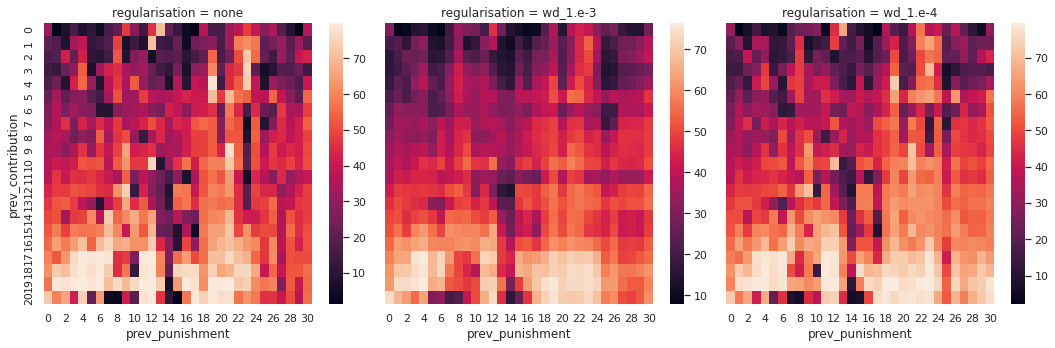

In [12]:
selection = best_labels['accuracy'].copy()

focus_dimension = 'regularisation'

selection.pop(focus_dimension)
# selection['regularisation'] = 'wd_1.e-6'

w = pd.concat(
    (synthethetic_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = synthethetic_df[focus_dimension].isin(['none', 'wd_1.e-3', 'wd_1.e-4'])

df = synthethetic_df[w & w2].copy()
df = df.sort_values(focus_dimension)

if df['y_encoding'].unique()[0] == 'ordinal':
    df['exp_contribution'] = df['proba']
else:
    df['exp_contribution'] = df['contribution'] * df['proba']


def _plot_heatmap(data, x, y, values):
    # groupby = list(set(df.columns) - set([x,y,values]))
    dfg = data.groupby([x,y])['exp_contribution'].sum()
    dfg = dfg.reset_index()
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    sns.heatmap(cm)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_contribution',y='prev_punishment', values='exp_contribution')

fg = sns.FacetGrid(df, col=focus_dimension, col_wrap=3, height=5)
fg.map_dataframe(plot_heatmap)